In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config

In [4]:
# Hyperparameters
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_GEN = 64  # Number of feature maps in generator
FEATURES_DISC = 64  # Number of feature maps in discriminator

In [5]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)],  # Mean
        [0.5 for _ in range(CHANNELS_IMG)],   # Std
    ),
])

In [6]:
# Load MNIST dataset
dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.49MB/s]


# Model

## Mô tả khối Generator
Sử dụng kiến trúc DCGAN (Deep Convolutional GAN) với các lớp ConvTranspose2d để tăng kích thước ảnh.

Input: Tensor nhiễu có kích thước (batch_size, noise_dim, 1, 1).

Output: Ảnh giả kích thước (batch_size, channels_img, 64, 64) (giá trị pixel trong khoảng [-1, 1]).

```
Block 1: (noise_dim → features_gen*8), kernel=4, stride=1, padding=0 → 4x4  
Block 2: (features_gen*8 → features_gen*4), kernel=4, stride=2, padding=1 → 8x8  
Block 3: (features_gen*4 → features_gen*2), kernel=4, stride=2, padding=1 → 16x16  
Block 4: (features_gen*2 → features_gen), kernel=4, stride=2, padding=1 → 32x32  
Lớp cuối: ConvTranspose2d (features_gen → channels_img), kernel=4, stride=2, padding=1 → 64x64  
Hàm kích hoạt cuối: Tanh()  
```
Mỗi block bao gồm:  
```
ConvTranspose2d → BatchNorm2d → ReLU  
```

In [7]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, noise_dim, channels_img, features_gen):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x noise_dim x 1 x 1
            self._block(noise_dim, features_gen * 8, 4, 1, 0),  # 4x4
            self._block(features_gen * 8, features_gen * 4, 4, 2, 1),  # 8x8
            self._block(features_gen * 4, features_gen * 2, 4, 2, 1),  # 16x16
            self._block(features_gen * 2, features_gen, 4, 2, 1),  # 32x32
            nn.ConvTranspose2d(features_gen, channels_img, 4, 2, 1),  # 64x64
            nn.Tanh(),  # Output between [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

## Mô tả khối Discriminator
Sử dụng các lớp Conv2d để giảm kích thước ảnh.

Input: Ảnh thật/giả kích thước (batch_size, channels_img, 64, 64).

Output: Xác suất ảnh thật (scalar trong khoảng [0, 1]).

```
Block 1: (channels_img → features_disc), kernel=4, stride=2, padding=1 → 32x32  
Block 2: (features_disc → features_disc*2), kernel=4, stride=2, padding=1 → 16x16  
Block 3: (features_disc*2 → features_disc*4), kernel=4, stride=2, padding=1 → 8x8  
Block 4: (features_disc*4 → features_disc*8), kernel=4, stride=2, padding=1 → 4x4  
Lớp cuối: Conv2d (features_disc*8 → 1), kernel=4, stride=2, padding=0 → 1x1  
Hàm kích hoạt cuối: Sigmoid()  
```
Mỗi block gồm:
```
Conv2d → BatchNorm2d → LeakyReLU(0.2)  
```

In [8]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_disc):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_disc, 4, 2, 1),  # 32x32
            nn.LeakyReLU(0.2),
            self._block(features_disc, features_disc * 2, 4, 2, 1),  # 16x16
            self._block(features_disc * 2, features_disc * 4, 4, 2, 1),  # 8x8
            self._block(features_disc * 4, features_disc * 8, 4, 2, 1),  # 4x4
            nn.Conv2d(features_disc * 8, 1, 4, 2, 0),  # 1x1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

# Initialization

In [15]:
# Initialize networks
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# Initialize weights
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

initialize_weights(gen)
initialize_weights(disc)

In [16]:
# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

In [17]:

# For visualization
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

# Labels for real and fake images
real_label = 1.0
fake_label = 0.0

# Training

In [18]:
# Training loop
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        fake = gen(noise)
        disc_fake = disc(fake.detach()).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) -> max log(D(G(z)))
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print training stats
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} "
                f"Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # Take first 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("MNIST Real", img_grid_real, global_step=step)
                writer_fake.add_image("MNIST Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [0/5] Batch 0/469 Loss D: 0.6956, loss G: 0.7781
Epoch [0/5] Batch 100/469 Loss D: 0.0150, loss G: 4.1002
Epoch [0/5] Batch 200/469 Loss D: 0.0041, loss G: 5.4074
Epoch [0/5] Batch 300/469 Loss D: 0.4787, loss G: 1.5389
Epoch [0/5] Batch 400/469 Loss D: 0.5368, loss G: 1.2081
Epoch [1/5] Batch 0/469 Loss D: 0.6396, loss G: 1.5408
Epoch [1/5] Batch 100/469 Loss D: 0.5041, loss G: 1.1645
Epoch [1/5] Batch 200/469 Loss D: 0.5462, loss G: 0.7991
Epoch [1/5] Batch 300/469 Loss D: 0.6010, loss G: 0.6728
Epoch [1/5] Batch 400/469 Loss D: 0.5486, loss G: 1.0960
Epoch [2/5] Batch 0/469 Loss D: 0.5184, loss G: 0.9748
Epoch [2/5] Batch 100/469 Loss D: 0.5411, loss G: 1.0304
Epoch [2/5] Batch 200/469 Loss D: 0.5464, loss G: 1.1798
Epoch [2/5] Batch 300/469 Loss D: 0.5868, loss G: 1.9517
Epoch [2/5] Batch 400/469 Loss D: 0.5178, loss G: 1.1844
Epoch [3/5] Batch 0/469 Loss D: 0.5611, loss G: 0.9051
Epoch [3/5] Batch 100/469 Loss D: 0.5535, loss G: 1.0195
Epoch [3/5] Batch 200/469 Loss D: 0.549

In [19]:
# Save models
torch.save(gen.state_dict(), "generator.pth")
torch.save(disc.state_dict(), "discriminator.pth")

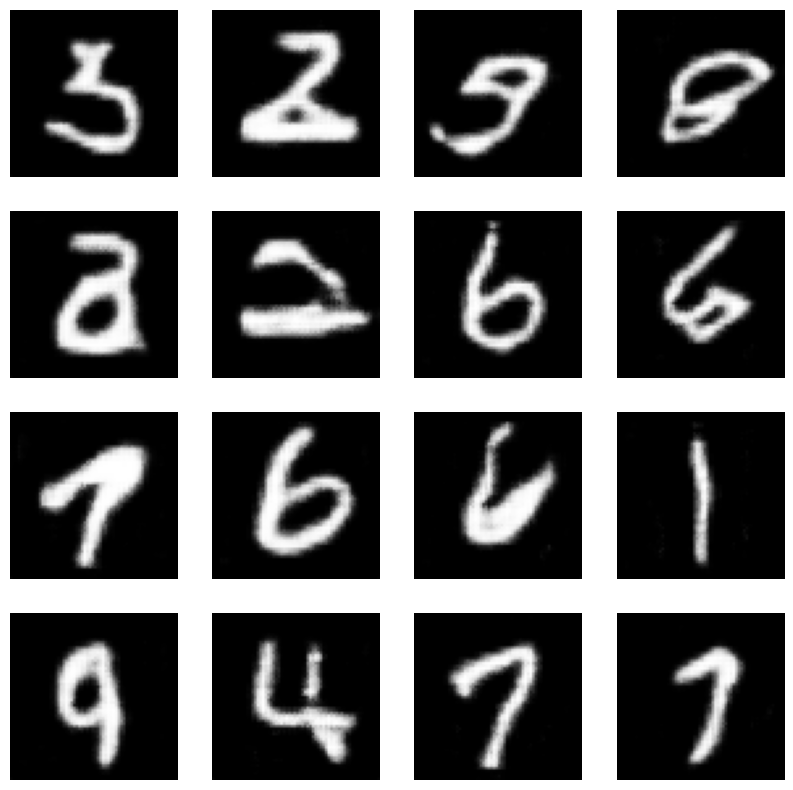

In [ ]:
# Generate some samples after training
with torch.no_grad():
    noise = torch.randn(16, NOISE_DIM, 1, 1).to(device)
    generated_images = gen(noise).cpu()

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()